# **Generative Adversarial Networks (GANs)**

In this lab we will practice the use of Generative Adversarial Networks (GANs) on images. The original paper is https://arxiv.org/abs/1406.2661

The purpose of the GANs is to generate new data instances. They learn the distribution of the training set and can generate new data never seen before.

It consists of two neural networks: a generator and a discriminator. The generator creates fake data from random noise, while the discriminator evaluates whether the data is real or fake.

During training, the generator aims to produce realistic data to fool the discriminator, and the discriminator learns to distinguish between real and fake data. This adversarial process continues until the generator produces data that the discriminator can no longer reliably identify as fake.

![Gan_image](https://media.licdn.com/dms/image/D5612AQHEdgJQaAOo8w/article-cover_image-shrink_600_2000/0/1684519028672?e=2147483647&v=beta&t=Zh3BO6wG6eYBfCoZzxnCdtvr9m0BXtQgQxyqq2LIrEY)

**LIBRARIES**

In [1]:
# we start importing some libraries
from numpy import zeros, ones, expand_dims, asarray
from numpy.random import randn, randint
from keras.datasets import fashion_mnist
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam, RMSprop, SGD
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import Conv2D, Conv2DTranspose, Concatenate
from keras.layers import LeakyReLU, Dropout, Embedding
from keras.layers import BatchNormalization, Activation
from keras import initializers
from keras.initializers import RandomNormal
import os
from matplotlib import pyplot as plt
import numpy as np
from math import sqrt
from tqdm import tqdm

# Set random seed for reproducibility
seed = 42

In [2]:
# Check if we have a GPU and if not use the CPU
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

    os.environ["CUDA_VISIBLE_DEVICES"] = "0"

else:
    print("Please install GPU version of TF")
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

Default GPU Device: /device:GPU:0


**Load fashion-MNIST dataset**

In this laboratory, we will use the fashion-MNIST dataset, that cointains MNIST-like fashion product images (https://github.com/zalandoresearch/), to train the Generator and the Discriminator; after training, the Generator will be able to generate images that resembles the original fashion-MNIST data.

The dataset consist of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28×28 grayscale image.

The choice of such data is guided by the fact the generated samples can be easily visually inspected to appreciate the quality.

In [44]:
# we load the data, the fashion_mnist dataset, and we visualize some examples
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Expand the dimensions of the images to change the shape from (60000, 28, 28) to (60000, 28, 28, 1) and (10000, 28, 28) to (10000, 28, 28, 1)
X_train = X_train.reshape(60000, 28, 28, 1) #--fill here--#
X_test = X_test.reshape(10000, 28, 28, 1) #--fill here--#


In [45]:
# Check if the shape is correct, if not raise an error
assert X_train.shape == (60000, 28, 28, 1) and X_test.shape == (10000, 28, 28, 1), f"Expected (60000, 28, 28, 1) and (10000, 28, 28, 1) but got {X_train.shape} and {X_test.shape} respectively"

**Preprocess data**

In [31]:
# The generator is using tanh activation in the last layer, because of that we need to preprocess
# the image data into a range between -1 and 1.

X_train = np.float32(X_train)
X_train = (X_train / 255) * 2 - 1


# Preprocess the test set in the same way as the train set

X_test = np.float32(X_test)
X_test = X_test.reshape(-1, 28*28) / 255.0  #--fill here--#

In [ ]:
# X_train  = (((X_train -X_train.min())/ (X_train.max() -X_train.min()))*2)-1
# X_test  = (((X_test  -X_test.min())/ (X_test.max() -X_test.min()))*2)-1

In [46]:
X_train = (X_train.astype("float32") / 255) * 2 - 1
X_test = (X_test.astype("float32") / 255) * 2 - 1

In [48]:
X_test.min()

-1.0

In [49]:
# Check if the data is in the correct range, if not raise an error
assert X_train.min() >= -1 and X_train.max() <= 1, f"X train is in the range [{X_train.min()}, {X_train.max()}]"
assert X_test.min() >= -1 and X_test.max() <= 1, f"X test is in the range [{X_test.min()}, {X_test.max()}]"

**Visualize some samples**

In [50]:
def plot_real_samples(num_samples,title=""):
    fig=plt.figure(figsize=(7,7))

    for k in range(num_samples):
        plt.subplot(int(np.sqrt(num_samples)), int(np.sqrt(num_samples)), k + 1, xticks=[], yticks=[])
        aux = np.squeeze(X_train[k])
        plt.imshow(((aux + 1)* 127).astype(np.uint8),cmap='gray')

    fig.suptitle(title)
    plt.show()

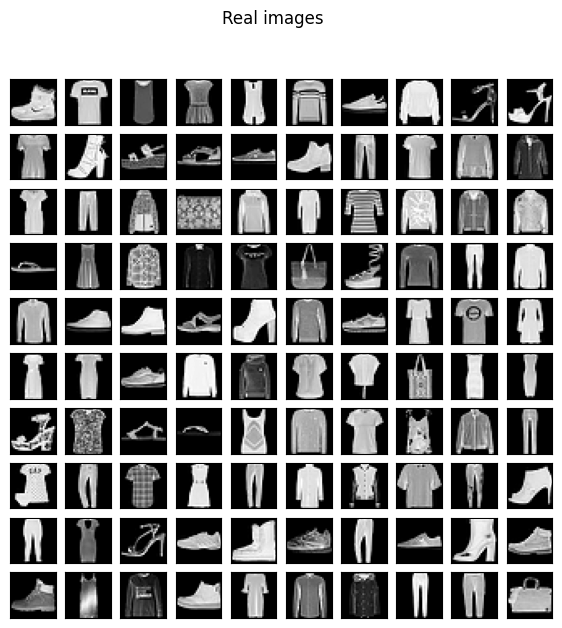

In [51]:
# we visualize some data
plot_real_samples(100,"Real images")

**Main steps of the GAN**

This function generates random latent points, which serve as inputs for the generator model. Given the latent dimension and the number of samples, the function creates a vector of random numbers from a standard normal distribution. It then reshapes this vector into a matrix with dimensions corresponding to the number of samples and the latent dimension, making it suitable for input into the generator

In [52]:
# A function to generate random inputs
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    z_input = x_input.reshape(n_samples, latent_dim)
    return z_input

This function samples real data points from the training dataset. Given the training data and the number of samples, the function randomly selects indices to extract the corresponding samples. It returns these samples along with a label array of ones, indicating that they are real data.

In [53]:
# A function to sample a training point
def sample_real_data(X_train, n_samples):
    ix = randint(0, X_train.shape[0], n_samples)
    X = X_train[ix]
    y = ones((n_samples, 1))
    return X, y

This function generates fake samples using a trained generator model. Given a random input defined by the latent dimension, the function uses this input to leverage the generator's predictive capabilities, producing images according to the architecture. This process occurs after the generator has been trained.

In [106]:
# A function to generate a fake input from a random point
def generate_fake_samples(generator, latent_dim, n_samples):
    z_input = generate_latent_points(latent_dim, n_samples)
    images = generator.predict(z_input, verbose=0)
    y = zeros((n_samples, 1))
    return images, y

This functions summarize the performance of the model and save the plot

In [55]:
def save_model(iteration, g_model, latent_dim, is_conv=False):
    if is_conv==False:
        directory = f"models_with_latent_dim_{latent_dim}"
    else:
        directory = f"conv_models_with_latent_dim_{latent_dim}"

    if not os.path.exists(directory):
        os.makedirs(directory)

    filename = os.path.join(directory, f'model_{iteration:04d}.h5')
    g_model.save(filename)
    print('>Saved: %s' % (filename))

**Define a random initializer for the networks' weights**

In [56]:
# As suggested by paper's authors, weights should be initialized
# with a Normal Distribution with standard deviation = 0.02
initializer = RandomNormal(stddev=0.02, seed=seed)

**Discriminator**

This component of the model attempts to differentiate between real images from the main dataset and fake images generated by the generator. Its goal is to correctly classify each input as real or fake. Ideally, the discriminator will become so effective that it will no longer be able to distinguish between real and fake images.

In [80]:
# define the structure of the discriminator (binary classifier real-fake)
def define_discriminator(in_shape=(28, 28, 1)):
    model = Sequential()

    model.add(Flatten(input_shape=in_shape))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    model.add(Dense(512)) # Add a dense layer with 512 units
    model.add(LeakyReLU(alpha=0.1)) # Add a LeakyReLU layer with alpha=0.2
    model.add(Dropout(0.23)) # Add a Dropout layer with 0.3 probability

    # model.add(#--fill here--#) # Add a dense layer with 512 units
    # model.add(#--fill here--#) # Add a LeakyReLU layer with alpha=0.2
    # model.add(#--fill here--#) # Add a Dropout layer with 0.3 probability

    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    model.add(Dense(1, activation='sigmoid'))

    # compile model with the Adam optimizer with a learning rate of 0.0002
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model


In [81]:
# build the discriminator
discriminator = define_discriminator()
discriminator.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_21 (Dense)            (None, 1024)              803840    
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 1024)              0         
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_22 (Dense)            (None, 512)               524800    
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 512)               0         
                                                                 
 dropout_4 (Dropout)         (None, 512)              

**Set Latent Space Dimension**

The latent space dimension is responsible for the quality of the generated images

In [82]:
# Set the latent space dimension (try with different values, e.g. 5, and see what happens)
latent_dim = 100

**Generator**

This component generates images that closely resemble those in the original dataset by taking noise as input.

In [99]:
# define the generator
def define_generator(latent_dim):
    model = Sequential()

    model.add(Dense(256, kernel_initializer=initializer, input_shape=(latent_dim,)))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dense(512, kernel_initializer=initializer))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dense(1024, kernel_initializer=initializer))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(28 * 28 * 1, kernel_initializer=initializer))

    model.add(Activation('tanh')) # Add a tanh activation function
    model.add(Reshape((28, 28, 1)))

    return model

In [100]:
# build the generator
generator = define_generator(latent_dim)
generator.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 256)               25856     
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 256)               0         
                                                                 
 dense_34 (Dense)            (None, 512)               131584    
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (None, 512)               0         
                                                                 
 dense_35 (Dense)            (None, 1024)              525312    
                                                                 
 leaky_re_lu_26 (LeakyReLU)  (None, 1024)              0         
                                                                 
 dense_36 (Dense)            (None, 784)              

**Build the GAN model**

This function sets up a GAN by combining a generator (g_model) and a non-trainable discriminator (d_model). It links the generator's output to the discriminator's input, creating a model that outputs the discriminator's classification.

In [101]:
# define the GANs architecture
def define_gan(g_model, d_model):
    d_model.trainable = False
    gan_output = d_model(g_model.output)
    model = Model(g_model.input, gan_output)
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [102]:
gan_model = define_gan(generator, discriminator)
gan_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33_input (InputLayer  [(None, 100)]             0         
 )                                                               
                                                                 
 dense_33 (Dense)            (None, 256)               25856     
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 256)               0         
                                                                 
 dense_34 (Dense)            (None, 512)               131584    
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (None, 512)               0         
                                                                 
 dense_35 (Dense)            (None, 1024)              525312    
                                                           

**Loss, Accuracy and Display generated samples functions**

In [103]:
# Loss and Accuracy plots
def plot_loss_and_acc(d_loss, g_loss, d_acc, dim=(12,4), is_conv=False):
    plt.figure(figsize=dim)
    plt.subplot(1, 2, 1)  # Create the first subplot for loss
    plt.plot(d_loss, label='Discriminator')
    plt.plot(g_loss, label='Generator')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Iteration')
    plt.legend(loc='upper right')

    plt.subplot(1, 2, 2)  # Create the second subplot for accuracy
    plt.plot(d_acc, label='Discriminator')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Iteration')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.savefig('loss_acc_plot.png') if is_conv==False else plt.savefig('conv_loss_acc_plot.png')
    plt.show()
    plt.close()

# using the function predict() generate num_samples samples and plot it using plt.imshow
def plot_generated_samples(generator,num_samples,title=""):
    x_fake = generator.predict(generate_latent_points(latent_dim, num_samples))
    fig = plt.figure(figsize=(7,7))
    for k in range(num_samples):
        plt.subplot(int(np.sqrt(num_samples)), int(np.sqrt(num_samples)), k + 1, xticks=[], yticks=[])
        aux = np.squeeze(x_fake[k])
        plt.imshow(((aux + 1)* 127).astype(np.uint8), cmap='gray')
    fig.suptitle(title)
    plt.show()

**Train the GAN model**

In order to train the model, we can use the train_on_batch function provides by Keras (https://keras.io/api/models/model_training_apis/#trainonbatch-method)

In [125]:
# Training function
def train(g_model, d_model, gan_model, X_train, latent_dim, iterations=1400, batch_size=128, is_conv=False):

    print(f"---- Starting the training for {iterations} training iterations ---\n")
    # Initialize lists to store the loss and accuracy values
    d_loss_vec = []
    g_loss_vec = []
    d_acc_vec = []
    g_acc_vec = []
    # Iterate over the total number of training steps
    for i in tqdm(range(iterations)):

        # Sample real data and generate fake data
        X_real, y_real = sample_real_data(X_train, batch_size)
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, batch_size)

        # Train the discriminator on real data / fake data and record the loss and accuracy
        d_loss_r, d_acc_r = d_model.train_on_batch(X_real, y_real)
        d_loss_f, d_acc_f = d_model.train_on_batch(X_fake, y_fake) #--fill here--# # Use the train_on_batch method to train the discriminator on the fake data

        # Calculate the discriminator loss and accuracy for the batch
        d_loss_batch = d_loss_r + d_loss_f
        d_acc_batch = 0.5 * (d_acc_r + d_acc_f)

        # Generate latent points as input for the generator
        z_input =  generate_latent_points(latent_dim, 128) #tf.randn((100, latent_dim)) #--fill here--# # Use the generate_latent_points function to generate latent points

        # Create labels for the generator (all ones to indicate fake images as real)
        y_gan = np.ones((batch_size, 1))

        # Train the generator via the combined GAN model and record the loss
        g_loss, g_acc = gan_model.train_on_batch(z_input, y_gan)

        # Append the generator and discriminator loss for the batch
        d_loss_vec.append(d_loss_batch)
        d_acc_vec.append(d_acc_batch)
        g_loss_vec.append(g_loss)
        g_acc_vec.append(g_acc)

        # Every 1000 steps, summarize performance, display generated samples and plot the metrics
        if (i+1) % 1000 == 0:
            plot_generated_samples(g_model,36)
            plot_loss_and_acc(d_loss_vec, g_loss_vec, d_acc_vec, is_conv=is_conv)
            save_model(i+1, g_model, latent_dim, is_conv=is_conv)
            print(f"Iteration {i+1}/{iterations} - Discriminator Loss: {d_loss_batch:.4f}, Generator Loss: {g_loss:.4f} - Discriminator Accuracy: {d_acc_batch:.4f}")

In [126]:
train(generator, discriminator, gan_model, X_train, latent_dim, iterations=10000, batch_size=128, is_conv=False)

Output hidden; open in https://colab.research.google.com to view.

**Load the trained model and display the results**

Load one of trained models (saved every 1000 iterations) and see the generated samples!

```
['model_1000.h5', 'model_2000.h5', 'model_3000.h5', ..., 'model_9000.h5', 'model_10000.h5']
```

**Try a different latent space**

Try to reduce the size of the latent space (e.g. to 5) and see what happens to the generated samples!


Loaded the model: model_10000.h5 trained with a latent dim of 100
2/2 [==============================] - 0s 5ms/step


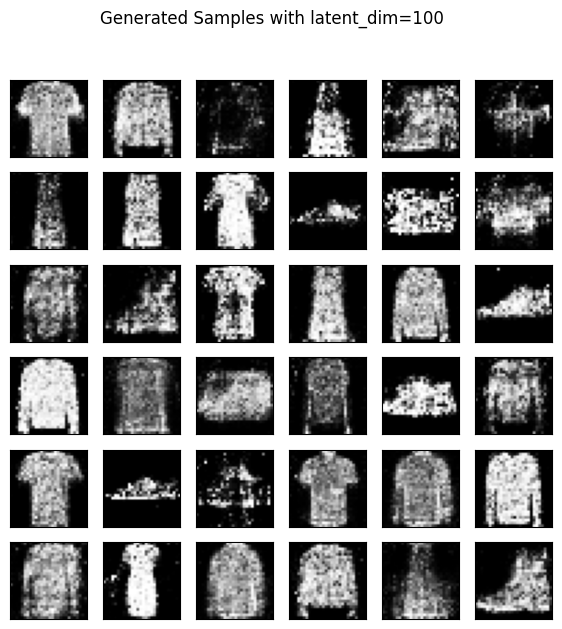

In [127]:
latent_dim = 100  # <-- PUT HERE THE LATENT DIMENSION OF YOUR TRAINED MODEL!!
model_name = "model_10000.h5" # <-- PUT HERE THE NAME OF YOUR TRAINED MODEL!!

# load one of the saved models
generator = load_model(f"models_with_latent_dim_{latent_dim}/{model_name}")
print(f"Loaded the model: {model_name} trained with a latent dim of {latent_dim}")

# display the generated samples
plot_generated_samples(generator, 36, title=f"Generated Samples with latent_dim={latent_dim}")

# **Deep Convolutional Generative Adversarial Network (DCGAN)**

At https://arxiv.org/pdf/1511.06434.pdf you can find the Deep Convolutional Generative Adversarial Network (DCGAN) paper: this latter has lot of useful suggestions in terms of settings about the architecture, the optimizers and the hyperparameters to use.

**Define the Convolutional Generator**

The Generator takes as input random noise (low dimensionality, e.g. 100) and produce an image (high dimensionality, e.g. 28 x 28 x 3): in order to perform the upsampling operation we can use the transposed convolution (Conv2DTranspose in Keras).

The first layer of the Generator is a Dense layer that takes random noise as input (of dimension latent_dim) and upsample it through layers in order to obtain the size of the image (in this case 28x28x1).

After each Conv2DTranspose layer we add a BatchNormalization and a LeakyRelu activation layer. The output layer uses tanh activation in order to output an image in [-1,1].

For more see: https://www.tensorflow.org/tutorials/generative/dcgan

In [128]:
#Define a random initializer for the networks' weights
initializer = RandomNormal(stddev=0.02, seed=seed)

In [129]:
# Define the latent space dimension
latent_dim = 100

In [143]:
def define_conv_generator(latent_dim):

    # 7x7x256
    model = Sequential()
    model.add(Dense(7*7*256, use_bias=False, input_shape=(latent_dim,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    # 14x14x128
    model.add(Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    # 14x14x64
   # model.add(#--fill here--#) # Add a Conv2DTranspose layer with 64 filters, kernel size of 5x5, stride of 2x2, padding='same'
    model.add(Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(BatchNormalization()) # Add a BatchNormalization layer
    model.add(LeakyReLU()) # Add a LeakyReLU layer


    # 28x28x1
    #model.add(#--fill here--#) # Add a Conv2DTranspose layer with 1 filter, kernel size of 5x5, stride of 2x2, padding='same', no bias and tanh activation
    model.add(Conv2DTranspose(1, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [144]:
conv_generator = define_conv_generator(latent_dim)
conv_generator.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 12544)             1254400   
                                                                 
 batch_normalization_6 (Bat  (None, 12544)             50176     
 chNormalization)                                                
                                                                 
 leaky_re_lu_35 (LeakyReLU)  (None, 12544)             0         
                                                                 
 reshape_8 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_6 (Conv2D  (None, 7, 7, 128)         819200    
 Transpose)                                                      
                                                                 
 batch_normalization_7 (Bat  (None, 7, 7, 128)       

**Plot samples generated by the Generator before training**

1/1 [==============================] - 0s 118ms/step


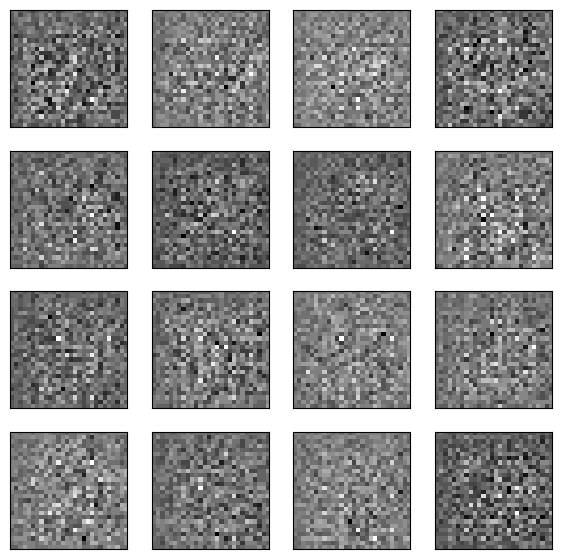

In [145]:
plot_generated_samples(conv_generator,16)

**Define the Convolutional Discriminator**

The Discriminator is a Convolutional Neural Network (CNN) that distinguish between real and generated samples (basically it is a binary classification problem)

In [146]:
def define_conv_discriminator(in_shape=(28, 28, 1)):

    # 14x14x64
    model = Sequential()
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    # 7x7x128
    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    # Flatten layer
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model with the Adam optimizer
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    return model

In [147]:
input_shape = X_train.shape[1:]
print(input_shape)

conv_discriminator = define_conv_discriminator(input_shape)
conv_discriminator.summary()

(28, 28, 1)
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_38 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_8 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_39 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 dropout_9 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_3 (Flatten)         (None, 6272)

**Define the DCGAN model**

In order to create the DCGAN model in Keras you should create a Model that incorporate both the Generator and the Discriminator.

In this lab we use Adam optimizer, as suggested in the DCGAN paper, but you can change it (e.g. SGD, RMSprop, etc..) and the hyperparameters (learning rate, momentum, etc..) to see how it affects the training phase.

In [148]:
# define the GANs architecture
def define_gan(g_model, d_model):
    d_model.trainable = False
    gan_output = d_model(g_model.output)
    model = Model(g_model.input, gan_output)
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [149]:
dcgan_model = define_gan(conv_generator, conv_discriminator)
dcgan_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40_input (InputLayer  [(None, 100)]             0         
 )                                                               
                                                                 
 dense_40 (Dense)            (None, 12544)             1254400   
                                                                 
 batch_normalization_6 (Bat  (None, 12544)             50176     
 chNormalization)                                                
                                                                 
 leaky_re_lu_35 (LeakyReLU)  (None, 12544)             0         
                                                                 
 reshape_8 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_6 (Conv2D  (None, 7, 7, 128)         8192

**Training the DCGAN**

In [150]:
train(conv_generator, conv_discriminator, dcgan_model, X_train, latent_dim, iterations=10000, batch_size=128, is_conv=True)

Output hidden; open in https://colab.research.google.com to view.

**Load the DCGAN model and visualize the generated samples**

Loaded the model: model_10000.h5 trained with a latent dim of 100
2/2 [==============================] - 0s 7ms/step


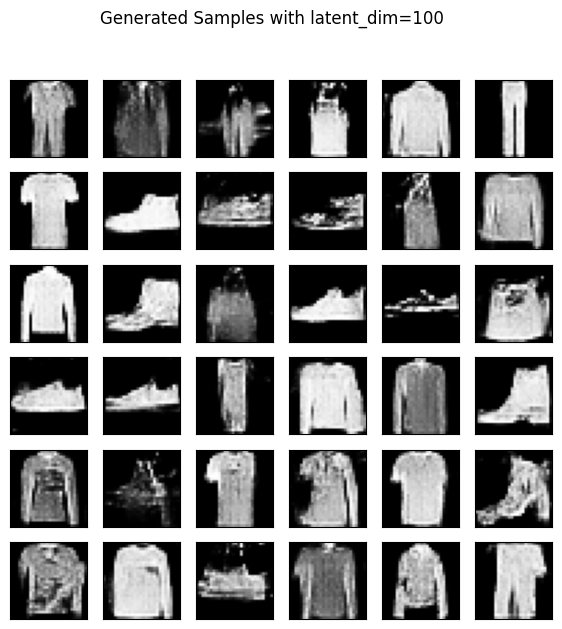

In [151]:
latent_dim = 100  # <-- PUT HERE THE LATENT DIMENSION OF YOUR TRAINED MODEL!!
model_name = "model_10000.h5" # <-- PUT HERE THE NAME OF YOUR TRAINED MODEL!!

# load one of the saved models
conv_generator = load_model(f"conv_models_with_latent_dim_{latent_dim}/{model_name}")
print(f"Loaded the model: {model_name} trained with a latent dim of {latent_dim}")

# display the generated samples
plot_generated_samples(conv_generator, 36, title=f"Generated Samples with latent_dim={latent_dim}")

# Display the real and the GAN / DCGAN generated images**

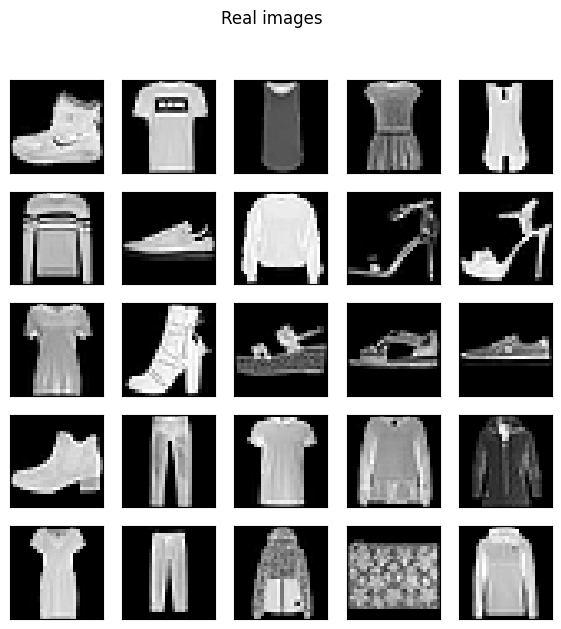

1/1 [==============================] - 0s 118ms/step


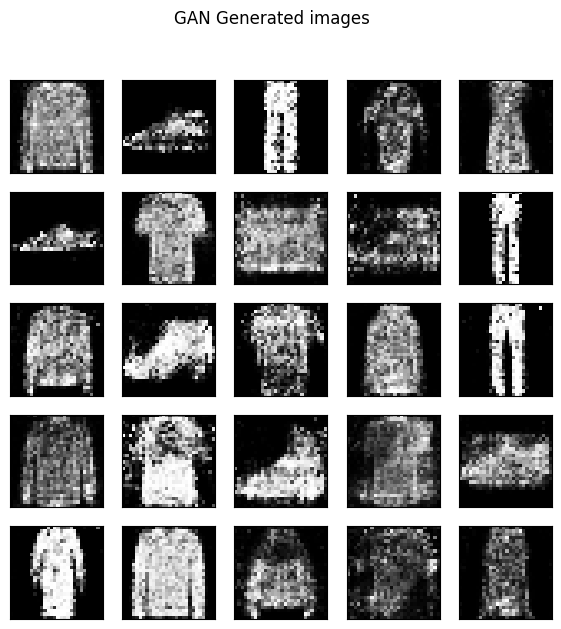

1/1 [==============================] - 0s 396ms/step


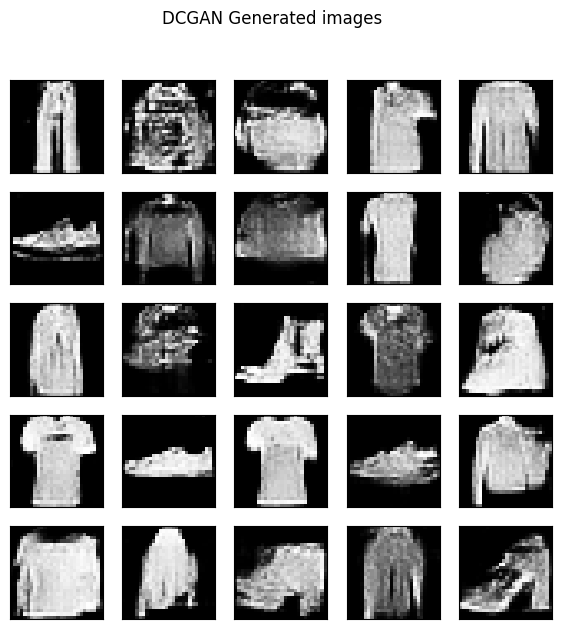

In [152]:
latent_dim = 100  # <-- PUT HERE THE LATENT DIMENSION OF YOUR TRAINED MODEL!!
model_name = "model_10000.h5" # <-- PUT HERE THE NAME OF YOUR TRAINED MODEL!!

generator = load_model(f"models_with_latent_dim_{latent_dim}/{model_name}")
conv_generator = load_model(f"conv_models_with_latent_dim_{latent_dim}/{model_name}")

plot_real_samples(25, "Real images")
plot_generated_samples(generator, 25, "GAN Generated images")
plot_generated_samples(conv_generator, 25, "DCGAN Generated images")